### Author: Ran Meng

This jupyter notebook contains my work for certification of "Generalized Linear Models in Python" instructed by Ita Cirovic Donev, from [DataCamp](https://learn.datacamp.com/courses/generalized-linear-models-in-python)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
from statsmodels.formula.api import ols, glm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrix

#### Linear model, a special case of GLM

In this exercise you will fit a linear model two ways, one using the ols() function and one using the glm() function. This will show how a linear model is a special case of a generalized linear model (GLM).

You will use the preloaded salary dataset introduced in the video.

Recall that the linear model in Python is defined as:

ols(formula = 'y ~ X', data = my_data).fit()

and the generalized linear model can be trained using

glm(formula = 'y ~ X', data = my_data, family = sm.families.___).fit()

In [2]:
salary = pd.read_csv('salary.csv')

salary.head()

,Experience,Salary
0,1.1,39343.0
1,1.3,46205.0
2,1.5,37731.0
3,2.0,43525.0
4,2.2,39891.0


In [3]:
# Fit a linear model
model_lm = ols(formula = 'Salary ~ Experience',
               data = salary).fit()

# View model coefficients
print(model_lm.params)

Intercept     25792.200199
Experience     9449.962321
dtype: float64


#### Linear model and a binary response variable

In the video, you saw an example of fitting a linear model to a binary response variable and how things can go wrong quickly. You learned that, given the linear line fit, you can obtain fitted values 
, which are not in line with the logic of the problem since the response variable takes on values 0 and 1.

Using the preloaded crab dataset, you will study this effect by modeling y as a function of x using the GLM framework.

Recall that the GLM model formulation is:

glm(formula = 'y ~ X', data = my_data, family = sm.families.____).fit()

where you specify formula, data, and family.

Also, recall that a GLM with:

the Gaussian family is a linear model (a special case of GLMs)
the Binomial family is a logistic regression model.

In [4]:
crab = pd.read_csv('crab.csv')

crab.shape

(173, 8)

In [5]:
crab.head()

,crab,sat,y,weight,width,color,spine,width_C
0,1,8,1,3.05,28.3,2,3,"[28.25, 29.25)"
1,2,0,0,1.55,22.5,3,3,"[0.0, 23.25)"
2,3,9,1,2.30,26.0,1,1,"[25.25, 26.25)"
3,4,0,0,2.10,24.8,3,3,"[24.25, 25.25)"
4,5,4,1,2.60,26.0,3,3,"[25.25, 26.25)"


In [6]:
# Define model formula
formula = 'y ~ width'

# Define probability distribution for the response variable for 
# the linear (LM) and logistic (GLM) model
family_LM = sm.families.Gaussian()
family_GLM = sm.families.Binomial()

# Define and fit a linear regression model
model_LM = glm(formula = formula, data = crab, family = family_LM).fit()
print(model_LM.summary())

# Define and fit a logistic regression model
model_GLM = glm(formula = formula, data = crab, family = family_GLM).fit()
print(model_GLM.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  173
Model:                            GLM   Df Residuals:                      171
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                         0.19515
Method:                          IRLS   Log-Likelihood:                -103.13
Date:                Mon, 15 Mar 2021   Deviance:                       33.371
Time:                        00:49:35   Pearson chi2:                     33.4
No. Iterations:                     3   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7655      0.421     -4.190      0.000      -2.591      -0.940
width          0.0915      0.016      5.731      0.0

In [7]:
test = pd.read_csv('crab_test.csv')

test.head()

,width,y
0,17.8,0
1,24.6,0
2,28.1,1
3,32.0,1
4,33.7,1


In [8]:
# Compute estimated probabilities for linear model: pred_lm
pred_lm = model_LM.predict(test)

# Compute estimated probabilities for GLM model: pred_glm
pred_glm = model_GLM.predict(test)

# Create dataframe of predictions for linear and GLM model: predictions
predictions = pd.DataFrame({'Pred_LM': pred_lm, 'Pred_GLM': pred_glm})

# Concatenate test sample and predictions and view the results
all_data = pd.concat([test, predictions], axis = 1)
print(all_data)



   width  y   Pred_LM  Pred_GLM
0   17.8  0 -0.136287  0.029309
1   24.6  0  0.486122  0.470299
2   28.1  1  0.806480  0.834983
3   32.0  1  1.163450  0.972363
4   33.7  1  1.319052  0.987941


Excellent! Comparing the predicted values for both models, the GLM model provides values within the (0,1) range as is required by the binary response variable. How to arrive at the specific class, 0 or 1, we will cover in the next chapter.

#### Model fitting step-by-step

In the video lecture, you learned the key components for fitting a GLM in Python using the statsmodels package. In this exercise you will define the components of the GLM step by step and finally fit the model by calling the .fit() method.

The dataset which you will use is on the contamination of groundwater with arsenic in Bangladesh where we want to model the household decision on switching the current well.
The columns in the dataset are:

switch: 1 if the change of the current well occurred; 0 otherwise

arsenic: The level of arsenic contamination in the well

distance: Distance to the closest known safe well

education: Years of education of the head of the household

In [9]:
wells = pd.read_csv('wells.csv')

wells.head()

,switch,arsenic,distance,assoc,education,distance100,education4
0,1,2.36,16.826000,0,0,0.16826,0
1,1,0.71,47.321999,0,0,0.47322,0
2,0,2.07,20.966999,0,10,0.20967,2
3,1,1.15,21.486000,0,12,0.21486,2
4,1,1.10,40.874001,1,14,0.40874,3


In [10]:
print(wells.shape)

(3010, 7)


In [11]:
# Define the formula the the logistic model
model_formula = 'switch ~ distance100'

# Define the correct probability distribution and the link function of the response variable
link_function = sm.families.links.logit
model_family = sm.families.Binomial(link = link_function)

# Fit the model
wells_fit = glm(formula = model_formula, 
                 data = wells, 
                 family = model_family).fit()

In [12]:
# View the results of the wells_fit model
print(wells_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 switch   No. Observations:                 3010
Model:                            GLM   Df Residuals:                     3008
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2030.6
Date:                Mon, 15 Mar 2021   Deviance:                       4061.3
Time:                        00:49:35   Pearson chi2:                 3.01e+03
No. Iterations:                     4   Covariance Type:             nonrobust
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.6108      0.060     10.104      0.000       0.492       0.729
distance100    -0.6291      0.098     -6.446     

#### Extracting parameter estimates

Coefficient estimates are generally of main interest in a regression model. In the previous exercise you learned how to view the results of the model fit and hence the coefficient values along with their corresponding statistics. In this exercise you will learn how to extract the coefficients from the model object.

The attribute .params contains the coefficients of the fitted model, starting with the intercept value. To compute a 95% confidence interval for the coefficients you can use the method .conf_int() of the fitted model wells_fit.

In [13]:
# Extract coefficients from the fitted model wells_fit
intercept, slope = wells_fit.params

# Print coefficients
print('Intercept =', intercept)
print('Slope =', slope)

# Extract and print confidence intervals
print(wells_fit.conf_int())

Intercept = 0.6108118803818955
Slope = -0.6290808479557684
                    0         1
Intercept    0.492327  0.729297
distance100 -0.820345 -0.437816


## Modelling Binary Data (Logistic Regression)

#### Fit logistic regression

In this exercise, you will continue with the data from the study on the contamination of ground water with arsenic in Bangladesh where you want to model the probability of switching the current well given the level of arsenic present in the well.

In [14]:
# Fit logistic regression model
model_GLM = glm(formula = 'switch~arsenic',
                data = wells,
                family = sm.families.Binomial()).fit() 

# Print model summary
print(model_GLM.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                 switch   No. Observations:                 3010
Model:                            GLM   Df Residuals:                     3008
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1997.3
Date:                Mon, 15 Mar 2021   Deviance:                       3994.6
Time:                        00:49:35   Pearson chi2:                 3.03e+03
No. Iterations:                     4   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3058      0.070     -4.340      0.000      -0.444      -0.168
arsenic        0.3799      0.039      9.837      0.0

#### Coefficients in terms of odds

Previously you have fitted a logistic regression model for the probability of switching the well given the arsenic levels. In this exercise, you will see how another variable distance100 relates to the probability of switching and interpreting the coefficient values in terms of odds.

Recall that the logistic regression model is in terms of log odds, so to obtain by how much would the odds multiply given a unit increase in x you would exponentiate the coefficient estimates. This is also called odds ratio.

Recall that **odds are a ratio of event occurring to the event not occurring**. For example, if the odds of winning a game are 1/2 or 1 to 2 (1:2), it means that for every one win there are 2 losses.

In [15]:
# Fit logistic regression model
model_GLM = glm(formula = 'switch~distance100',
                data = wells,
                family = sm.families.Binomial()).fit()

# Extract model coefficients
print('Model coefficients: \n', model_GLM.params)

# Compute the multiplicative effect on the odds
print('\nOdds: \n', np.exp(model_GLM.params))

# The odds of switching the well is 1/2 for a 1-unit (100m) increase in distance, 
# so for every one switch (household switches to the nearest safe well) there would be 2 households 
# who would not switch to the nearest safe well.

Model coefficients: 
 Intercept      0.610812
distance100   -0.629081
dtype: float64

Odds: 
 Intercept      1.841926
distance100    0.533082
dtype: float64


In [16]:
print(model_GLM.summary())

# log(p/(1-p)) = -0.6291 * distance100 + 0.6108
# With one-unit increase in distance100 the log odds decrease by -0.6291.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 switch   No. Observations:                 3010
Model:                            GLM   Df Residuals:                     3008
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2030.6
Date:                Mon, 15 Mar 2021   Deviance:                       4061.3
Time:                        00:49:35   Pearson chi2:                 3.01e+03
No. Iterations:                     4   Covariance Type:             nonrobust
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.6108      0.060     10.104      0.000       0.492       0.729
distance100    -0.6291      0.098     -6.446     

#### Rate of change in probability

For the wells dataset you have already fitted a logistic regression model with the model formula switch ~ distance100 obtaining the following fit

                        log(p/(1-p)) = -0.6291 * distance100 + 0.6108
                        
where p = P(y = 1)


In this exercise you will use that model to understand how the estimated probability changes at a certain value of distance100, say 1.5

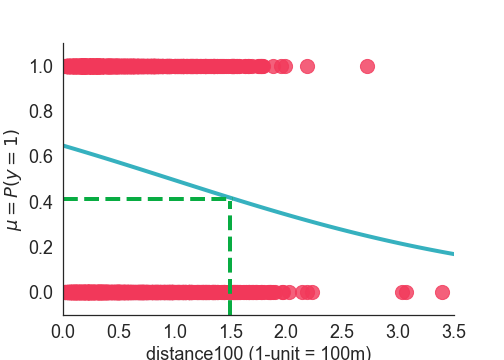

Recall the formulas for the **inverse-logit** (probability)

$ \mu = \frac{exp(\beta_0+\beta_1x_1)}{1+exp(\beta_0+\beta_1x_1)} $

and the slope of the tangent line of the model fit at point :

$\beta*\mu(1-\mu)$



In [17]:
# Define x at 1.5
x = 1.5

# Extract intercept & slope from the fitted model
intercept, slope = model_GLM.params
print(intercept)
print(slope)

0.6108118803818955
-0.6290808479557684


In [18]:
# Compute and print the estimated probability
est_prob = np.exp(intercept + slope*x)/(1+np.exp(intercept + slope*x))
print('Estimated probability at x = 1.5: ', round(est_prob, 4))

Estimated probability at x = 1.5:  0.4176


In [19]:
# Compute the slope of the tangent line for parameter beta at x
slope_tan = slope * est_prob * (1 - est_prob)
print('The rate of change in probability: ', round(slope_tan,4))

# So at the distance100 value of 1.5 the estimated probability is 0.418 with the rate of change in the estimated probability of negative 0.153. 
# This means that for every 1oo m increase in distance100 at the distance100 value of 1.5 
# the probability of well switch decreases by 15.3%.

The rate of change in probability:  -0.153


#### Statistical significance

In the video we analyzed the horseshoe crab model by predicting y with weight. In this exercise you will assess the significance of the estimated coefficients but with width as explanatory variable instead.

Recall that coefficients help us determine the significance of the relationship that we are trying to model, where a positive sign increases the probability of an event as the predictor increases and vice versa.

In [20]:
# Fit logistic regression and save as crab_GLM
crab_GLM = glm('y ~ width', data = crab, family = sm.families.Binomial()).fit()

# Print model summary
print(crab_GLM.summary())

# There is a positive significant relationship (width increases the chance of a satellite)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  173
Model:                            GLM   Df Residuals:                      171
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -97.226
Date:                Mon, 15 Mar 2021   Deviance:                       194.45
Time:                        00:49:35   Pearson chi2:                     165.
No. Iterations:                     4   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.3508      2.629     -4.698      0.000     -17.503      -7.199
width          0.4972      0.102      4.887      0.0

In [21]:
# Extract coefficients
intercept, slope = crab_GLM.params

# Estimated covariance matrix: crab_cov
crab_cov = crab_GLM.cov_params()
print(crab_cov)

# Compute standard error (SE): std_error
std_error = np.sqrt(crab_cov.loc['width', 'width'])
print('SE: ', round(std_error, 4))

# Compute Wald statistic
wald_stat = slope/std_error
print('Wald statistic: ', round(wald_stat,4))

           Intercept     width
Intercept   6.910158 -0.266848
width      -0.266848  0.010350
SE:  0.1017
Wald statistic:  4.8875


#### Confidence intervals

Continuing from the previous exercise you will now asses the uncertainty of the coefficients by computing the confidence intervals.

Recall formulas for confidence intervals discussed in the video:

95% confidence intervals for the parameter:

$\hat\beta\pm1.96*SE$

95% confidence intervals for odds:

$exp(\hat\beta\pm1.96*SE)$

In [22]:
# Extract and print confidence intervals
print(crab_GLM.conf_int())

# Compute confidence intervals for the odds
print('\n', np.exp(crab_GLM.conf_int()))

                   0         1
Intercept -17.503010 -7.198625
width       0.297833  0.696629

                       0         1
Intercept  2.503452e-08  0.000748
width      1.346936e+00  2.006975


#### Visualize model fit using regplot()

After having fitted and analyzed the model we can visualize it by plotting the observation points and the fitted logistic regression.

Using the plot you can visually understand the relationship of the explanatory variable and the response for the range of values of the explanatory variable.

We can use the regplot() function from the seaborn module for this. The regplot() function takes an argument logistic, which allows you to specify whether you wish to estimate the logistic regression model for the given data using True or False values. This will also produce the plot of the fit.


Recall that the model that you fitted previously:

$\log\bigg(\frac{y}{1-y}\bigg) = -0.3058 + 0.3799*\text{arsenic}$


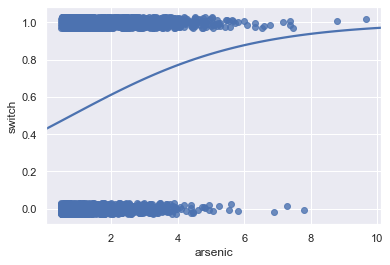

In [23]:
# Plot distance and switch and add overlay with the logistic fit
sns.set()
sns.regplot(x = 'arsenic', y = 'switch', 
            y_jitter = 0.03,
            data = wells, 
            logistic = True,
            ci = None)

# Display the plot
plt.show()

####  Compute predictions

Often, in practice, we are interested in using the fitted logistic regression to estimate the probabilities and construct confidence intervals for these estimates. Using the wells dataset and the model 'switch ~ arsenic' let's assume you have new observations wells_test which were not part of the training sample and you wish to predict the probability of switching to the nearest safe well.

In [24]:
wells_test = wells.sample(frac = 0.1, replace = False)

wells_test.head()

,switch,arsenic,distance,assoc,education,distance100,education4
454,1,3.69,80.427002,0,5,0.80427,1
1904,1,1.83,55.362000,1,5,0.55362,1
1108,0,0.52,21.146000,0,11,0.21146,2
1339,1,0.53,15.345000,0,0,0.15345,0
1300,1,2.24,33.330002,0,10,0.33330,2


In [25]:
# Compute predictions for the test sample wells_test and save as prediction
prediction = wells_fit.predict(exog = wells_test)

# Add prediction to the existing data frame wells_test and assign column name prediction
wells_test['prediction'] = prediction

# Examine the first 5 computed predictions
print(wells_test[['switch', 'arsenic', 'prediction']].head())

      switch  arsenic  prediction
454        1     3.69    0.526191
1904       1     1.83    0.565261
1108       0     0.52    0.617225
1339       1     0.53    0.625809
1300       1     2.24    0.598961


#### Compute confusion matrix

As you learned in the video the logistic regression model generates two types of predictions, a continuous valued prediction, in the form of a probability, and a class prediction which in the example of the wells dataset is a discrete category with two classes.

In the previous exercise you computed the continuous values prediction in the form of a probability. In this exercise you will use those values to assign a class to each observation in your wells_test sample. Finally you will describe the model using the confusion matrix.

In [26]:
# Define the cutoff
cutoff = 0.5

# Compute class predictions: y_prediction
y_prediction = np.where(prediction > cutoff, 1, 0)

In [27]:
# Assign actual class labels from the test sample to y_actual
y_actual = wells_test['switch']

# Compute and print confusion matrix using crosstab function
conf_mat = pd.crosstab(y_actual, y_prediction, 
                       rownames=['Actual'], 
                       colnames=['Predicted'], 
                       margins = True)
                      
# Print the confusion matrix
print(conf_mat)

Predicted   0    1  All
Actual                 
0          21   98  119
1          14  168  182
All        35  266  301


## Modelling Count Data (Poission Regression / Negative Binomial Regression)

#### Visualize the response

In the video you learned the main characteristics of the Poisson random variable and how its distribution changes as the parameter  changes. In this exercise, you will examine the response variable visually to assess the parameter value, spread of the distribution or its skewness.

You will use the crab dataset which you used in previous chapter exercises, but now you will analyze the number of satellite crabs sat, instead of whether there is at least one, near the nesting place.

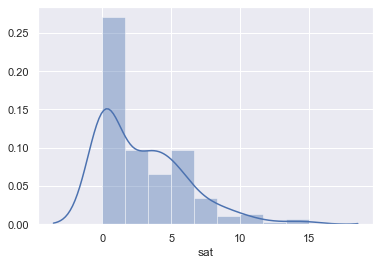

In [28]:
# Plot sat variable
sns.distplot(crab['sat'])

# Display the plot
plt.show()

In [29]:
# Fit Poisson regression of sat by weight
model = glm('sat ~ weight', data = crab, family = sm.families.Poisson()).fit()

# Display model results
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    sat   No. Observations:                  173
Model:                            GLM   Df Residuals:                      171
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -458.08
Date:                Mon, 15 Mar 2021   Deviance:                       560.87
Time:                        00:49:36   Pearson chi2:                     536.
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4284      0.179     -2.394      0.017      -0.779      -0.078
weight         0.5893      0.065      9.064      0.0

#### Estimate parameter lambda

In the video you learned how the log link function provides for the linear combination in the parameters defining the Poisson regression model of the form

$log(\lambda)=\beta_0+\beta_1x_1$

To obtain the response function in terms of lambda we exponentiated the model function to obtain

$\lambda=E(y)=exp(\beta_0 + \beta_1x_1)$

$\lambda=E(y)=exp(\beta_0) \times exp(\beta_1x_1)$

In this exercise, you will use this formulation with the horseshoe crab data to compute the estimate of the mean  for the female crab width.

In [30]:
# Fit Poisson regression of sat by width
crab_pois = glm('sat ~ width', data = crab, family = sm.families.Poisson()).fit()

# Display model results
print(crab_pois.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    sat   No. Observations:                  173
Model:                            GLM   Df Residuals:                      171
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -461.59
Date:                Mon, 15 Mar 2021   Deviance:                       567.88
Time:                        00:49:36   Pearson chi2:                     544.
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3048      0.542     -6.095      0.000      -4.368      -2.242
width          0.1640      0.020      8.216      0.0

In [31]:
# Extract coefficients
intercept, slope = crab_pois.params

# Compute and print the multiplicative effect
print(np.exp(slope))

# To conclude a 1-unit increase in female crab width the number of satellite crabs will increase, (multiplied by 1.18).

1.17826743864523


#### Poisson confidence intervals

Using the previously fitted horseshoes crab model sat ~ width analyze uncertainty of the coefficient estimates by computing the confidence intervals for  and the confidence intervals for the multiplicative effect on the mean.

In [32]:
# Compute confidence intervals for the coefficients
model_ci = crab_pois.conf_int()
print('Confidence internal for the coefficients: \n', model_ci)
# Compute and print the confidence intervals for the multiplicative effect on the mean
print('\nConfidence internal for the multiplicative effect on the mean: \n', np.exp(model_ci))

Confidence internal for the coefficients: 
                   0         1
Intercept -4.367531 -2.241983
width      0.124914  0.203176

Confidence internal for the multiplicative effect on the mean: 
                   0         1
Intercept  0.012683  0.106248
width      1.133051  1.225289


#### Is the mean equal to the variance?

Under the Poisson model one of the assumptions was that the mean should be the same as the variance. As you learned in the lecture, if this assumption is violated then there is overdispersion. Without adjusting for overdispersion you would wrongly interpret standard errors of the given model.

In this exercise you will first compute the mean and the variance of the number of satellites for the female crabs.

In [33]:
# Compute and print sample mean of the number of satellites: sat_mean
sat_mean = np.mean(crab.sat)

print('Sample mean:', round(sat_mean, 3))

# Compute and print sample variance of the number of satellites: sat_var
sat_var = np.var(crab.sat)
print('Sample variance:', round(sat_var, 3))

# Compute ratio of variance to mean
print('Ratio:', round(sat_var/sat_mean, 3))

# the variance is 3.37 times the mean. This gives an indication that Poisson GLM will not provide 
# the most accurate fit to the data. Let's do another check before moving on.

Sample mean: 2.919
Sample variance: 9.855
Ratio: 3.376


#### Computing expected number of counts

In the previous exercises you have computed the mean and variance of the crab data and you determined they are not equal. In this exercise you will practice another analysis for overdispersion by using the already computed mean and calculating the expected number of counts per certain value of counts, for example zero counts. In other words, what count of zero satellites should we expect in the sample given the computed sample mean.

Recall figure from the crab dataset where you can notice a large number of zero counts.
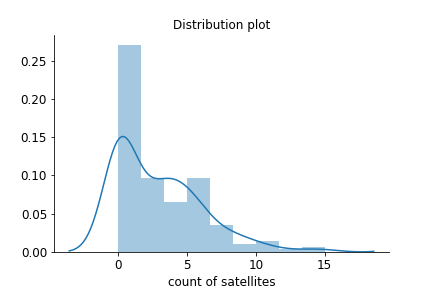

Recall that to compute the expected number of counts given the parameter you can use the defined Poisson distribution, 
given by

$P(y)=\frac{\lambda^ye^{-\lambda}}{y!}$

In [34]:
# Expected number of zero counts
exp_zero_cnt = ((sat_mean**0)*np.exp(-sat_mean))/math.factorial(0)

# Print exp_zero_counts
print('Expected zero counts given mean of ', round(sat_mean,3), 
      'is ', round(exp_zero_cnt,3)*100)

# Number of zero counts in sat variable
actual_zero_ant = sum(crab['sat']  == 0)

# Number of observations in crab dataset
num_obs = len(crab)

# Print the percentage of zero count observations in the sample
print('Actual zero counts in the sample: ', round(actual_zero_ant / num_obs,3)*100)

#Notice that given the mean parametar there should be 5.4% observations with zero count, 
# but in the crab #sample there are 35.8% observations with zero count, indicating the presence of overdispersion.

Expected zero counts given mean of  2.919 is  5.4
Actual zero counts in the sample:  35.8


#### Checking for overdispersion

In this exercise you will check for overdispersion in the model you fitted previously, namely the horseshoe crab Poisson model where you fitted sat given width. Recall from the video that to check for potential overdispersion in the fit you would compute the following

**model.pearson_chi2 / model.df_resid**

where .pearson_chi2 represents Pearson statistic and .df_resid represents the degrees of freedom of the residuals.

In [35]:
# Compute and print the overdispersion approximation
print(crab_pois.pearson_chi2 / crab_pois.df_resid)

# There is overdispersion present since the ratio is greater than 1, 
# meaning that the coefficient estimates should not be interpreted directly. 

3.182204743877359


#### Fitting negative binomial

The negative binomial allows for the variance to exceed the mean, which is what you have measured in the previous exercise in your data crab. In this exercise you will recall the previous fit of the Poisson regression using the log link function and additionally fit negative binomial model also using the log link function.

You will analyze and see how the statistical measures were changed.

In [36]:
# Define the formula for the model fit
formula = 'sat ~ width'

# Fit the GLM negative binomial model using log link function
crab_NB = glm(formula = formula, data = crab,
                  family = sm.families.NegativeBinomial()).fit()

# Print Poisson model's summary
print(crab_pois.summary())

# Print the negative binomial model's summary
print('\n', crab_NB.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    sat   No. Observations:                  173
Model:                            GLM   Df Residuals:                      171
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -461.59
Date:                Mon, 15 Mar 2021   Deviance:                       567.88
Time:                        00:49:36   Pearson chi2:                     544.
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3048      0.542     -6.095      0.000      -4.368      -2.242
width          0.1640      0.020      8.216      0.0

#### Confidence intervals for negative Binomial model

Continuing with the previously fitted crab model you will compare the confidence intervals for the negative Binomial model with the Poisson regression model.

In [37]:
# Compute confidence intervals for crab_Pois model
print('Confidence intervals for the Poisson model')
print(crab_pois.conf_int())

# Compute confidence intervals for crab_NB model
print('\n\nConfidence intervals for the Negative Binomial model')
print(crab_NB.conf_int())

# Notice how the confidence intervals are wider for the negative Binomial model
# compared to quite narrow confidence intervals for the Poisson model since it did not account for overdispersion.

Confidence intervals for the Poisson model
                  0         1
Intercept -4.367531 -2.241983
width      0.124914  0.203176


Confidence intervals for the Negative Binomial model
                  0         1
Intercept -6.244509 -1.820000
width      0.108155  0.274472


#### Plotting data and linear model fit

In the previous exercises you have practiced how to fit and interpret the Poisson regression model. In this exercise you will visually analyze the crab data and then the model fit.

First, you will plot a linear fit to the data, which later on you will use to compare to Poisson regression fitted values.

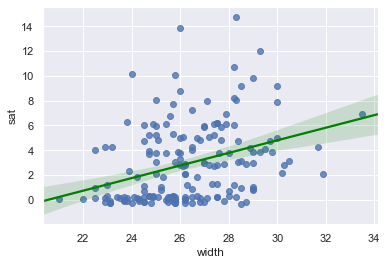

In [38]:
# Plot the data points and linear model fit
sns.regplot('width', 'sat', data = crab,
            y_jitter = 0.3,
            fit_reg = True,
            line_kws = {'color':'green', 
                        'label':'LM fit'})

# Print plot
plt.show()

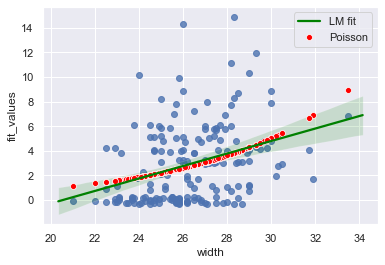

In [39]:
# Add fitted values to the fit_values column of crab dataframe
crab['fit_values'] = crab_pois.predict(crab['width'])

# Plot data points
sns.regplot('width', 'sat', data = crab,
            y_jitter = 0.3,
            fit_reg = True, 
            line_kws = {'color':'green', 
                        'label':'LM fit'})

# Poisson regression fitted values
sns.scatterplot('width','fit_values', data = crab,
           color = 'red', label = 'Poisson')

# Print plot          
plt.show()

## Multivariable Logistic Regression


#### Fit a multivariable logistic regression

Using the knowledge gained in the video you will revisit the crab dataset to fit a multivariate logistic regression model. In chapter 2 you have fitted a logistic regression with width as explanatory variable. In this exercise you will analyze the effects of adding color as additional variable.

The color variable has a natural ordering from medium light, medium, medium dark and dark. As such color is an ordinal variable which in this example you will treat as a quantitative variable.

In [40]:
crab.head()

,crab,sat,y,weight,width,color,spine,width_C,fit_values
0,1,8,1,3.05,28.3,2,3,"[28.25, 29.25)",3.810341
1,2,0,0,1.55,22.5,3,3,"[0.0, 23.25)",1.471463
2,3,9,1,2.30,26.0,1,1,"[25.25, 26.25)",2.612781
3,4,0,0,2.10,24.8,3,3,"[24.25, 25.25)",2.145904
4,5,4,1,2.60,26.0,3,3,"[25.25, 26.25)",2.612781


In [41]:
# Define model formula
formula = 'y ~ width + color'

# Fit GLM
model = glm(formula, data = crab, family = sm.families.Binomial()).fit()

# Print model summary
print(model.summary())

# Great work! You fitted your first multivariable logistic regression. From model summary note that for each one-level increase 
# in color of the female crab, the estimated odds multiply by exp(-0.509)=0.6,
# i.e. the odds for dark crabs are 60% than those for medium crabs.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  173
Model:                            GLM   Df Residuals:                      170
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -94.561
Date:                Mon, 15 Mar 2021   Deviance:                       189.12
Time:                        00:49:37   Pearson chi2:                     170.
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.0708      2.807     -3.588      0.000     -15.572      -4.569
width          0.4583      0.104      4.406      0.0

#### The effect of multicollinearity

Using the crab dataset you will analyze the effects of multicollinearity. Recall that multicollinearity can have the following effects:

- Coefficient is not significant, but variable is highly correlated with y.
- Adding/removing a variable significantly changes coefficients.
- Not logical sign of the coefficient.
- Variables have high pairwise correlation.

In [42]:
# Define model formula
formula = 'y ~ weight + width'

# Fit GLM
model = glm(formula, data = crab, family = sm.families.Binomial()).fit()

# Print model summary
print(model.summary())

#Notice that the neither weight nor width are statistically significant. 
# Recall that when we fitted univariate logistic regressions for each variable, both variables where statistically significant. 
# There is evident presence of multicollinearity! Let's measure it in the next exercise.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  173
Model:                            GLM   Df Residuals:                      170
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -96.446
Date:                Mon, 15 Mar 2021   Deviance:                       192.89
Time:                        00:49:37   Pearson chi2:                     167.
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.3547      3.528     -2.652      0.008     -16.270      -2.440
weight         0.8338      0.672      1.241      0.2

#### Compute VIF

As you learned in the video one of the most widely used diagnostic for multicollinearity is the variance inflation factor or VIF, which is computed for each explanatory variable.

Recall from the video that the rule of thumb threshold is VIF at the level of 2.5, meaning if the VIF is above 2.5 you should consider there is effect of multicollinearity on your fitted model.

In [43]:
# Get variables for which to compute VIF and add intercept term
X = crab[['weight', 'width', 'color']]
X['Intercept'] = 1

# Compute and view VIF
vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])] # (exog, exog_idx)

# View results using print
print(vif)

   variables         VIF
0     weight    4.691018
1      width    4.726378
2      color    1.076594
3  Intercept  414.163343


D:\Anaconda\envs\242\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### Checking model fit

In the video you analyzed the example of an improvement in the model fit by adding additional variable on the wells data. Continuing with this data set you will see how further increase in model complexity effects deviance and model fit.

In [44]:
# Define model formula
formula = 'switch ~ distance100 + arsenic'

# Fit GLM
model_dist_ars = glm(formula, data = wells, family = sm.families.Binomial()).fit()

# Compare deviance of null and residual model
diff_deviance = model_dist_ars.deviance - model_dist_ars.null_deviance

# Print the computed difference in deviance
print(diff_deviance)

# Having both distance100 and arsenic in the model reduces deviance by 187 compared to the intercept only model. 
# But what is the actual impact of additional variable arsenic? Let's see in the next exericise.

-188.76305963384902


In [45]:
# Define model formula
formula = 'switch ~ distance100'

# Fit GLM
model_dist = glm(formula, data = wells, family = sm.families.Binomial()).fit()

In [46]:
# Compute the difference in adding distance100 variable
diff_deviance_distance = -(model_dist.deviance - model_dist.null_deviance)

# Print the computed difference in deviance
print('Adding distance100 to the null model reduces deviance by: ', 
      round(diff_deviance_distance,3))

# Compute the difference in adding arsenic variable
diff_deviance_arsenic = -(model_dist_ars.deviance - model_dist.deviance)

# Print the computed difference in deviance
print('Adding arsenic to the distance model reduced deviance further by: ', 
      round(diff_deviance_arsenic,3))

Adding distance100 to the null model reduces deviance by:  42.726
Adding arsenic to the distance model reduced deviance further by:  146.037


Adding distance100 to the null model reduces deviance by 42.7 and with an addition of arsenic the deviance further reduces by 146. Having such large reduction than expected reduction by 1 we can conclude that the multivariate model has improved the model fit.

#### Deviance and linear transformation

As you have seen in previous exercises the deviance decreased as you added a variable that improves the model fit. In this exercise you will consider the well switch data example and the model you fitted with distance variable, but you will assess what happens when there is a linear transformation of the variable.

Note that the variable distance100 is the original variable distance divided by 100 to make for more meaningful representation and interpretation of the results. You can inspect the data with wells.head() to view the first 5 rows of data.

In [47]:
wells.head()

,switch,arsenic,distance,assoc,education,distance100,education4
0,1,2.36,16.826000,0,0,0.16826,0
1,1,0.71,47.321999,0,0,0.47322,0
2,0,2.07,20.966999,0,10,0.20967,2
3,1,1.15,21.486000,0,12,0.21486,2
4,1,1.10,40.874001,1,14,0.40874,3


In [48]:
# Fit logistic regression model as save as model_dist_1
model_dist_1 = glm('switch ~ distance', data = wells, family = sm.families.Binomial()).fit()

# Check the difference in deviance of model_dist_1 and model_dist
print('Difference in deviance is: ', round(model_dist_1.deviance - model_dist.deviance,3))

Difference in deviance is:  0.0


#### Model matrix for continuous variables

In the video you learned about the model formula, the under-the-hood workings of the dmatrix() to obtain the model matrix and how it relates to the glm() function. As you have learned the input to dmatrix() is the right hand side of the glm() formula argument. In case the variables are part of the dataframe, then you should also specify the data source via the data argument.

dmatrix('y ~ x1 + x2', 
        data = my_data)
        
In this exercise you will analyze and confirm the structure of your model before model fit.

In [49]:
# Construct model matrix with arsenic
model_matrix = dmatrix('arsenic', data = wells, return_type = 'dataframe')
print(model_matrix.head())

# dmatrix() includes an intercept

   Intercept  arsenic
0        1.0     2.36
1        1.0     0.71
2        1.0     2.07
3        1.0     1.15
4        1.0     1.10


In [50]:
# Construct model matrix with arsenic and distance100
model_matrix = dmatrix('arsenic + distance100', data = wells, return_type = 'dataframe')
print(model_matrix.head())

   Intercept  arsenic  distance100
0        1.0     2.36      0.16826
1        1.0     0.71      0.47322
2        1.0     2.07      0.20967
3        1.0     1.15      0.21486
4        1.0     1.10      0.40874


#### Variable transformation

Continuing with the wells you will practice applying variable transformation directly in the formula and model matrix setting without the need to add the transformed data to the data frame first. You will also revisit the computation of model error or deviance to see if the transformation improved the model fit.

Recall the structure of dmatrix() function is the right hand side of the glm() formula argument in addition to the data argument.

In [51]:
# Construct model matrix for arsenic with log transformation
dmatrix('np.log(arsenic)', data = wells,
       return_type = 'dataframe').head()

,Intercept,np.log(arsenic)
0,1.0,0.858662
1,1.0,-0.342490
2,1.0,0.727549
3,1.0,0.139762
4,1.0,0.095310


In [52]:
# Define model formula
formula = 'switch ~ np.log(arsenic)'

# Fit GLM
model_log_ars = glm(formula, data = wells, 
                     family = sm.families.Binomial()).fit()

# Print model summary
print(model_log_ars.summary())


# Define model formula without log transformation
formula = 'switch ~ arsenic'

# Fit GLM
model_ars = glm(formula, data = wells, 
                     family = sm.families.Binomial()).fit()


print('\n\n\nDeviance without log transformation: \n', model_ars.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 switch   No. Observations:                 3010
Model:                            GLM   Df Residuals:                     3008
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1987.6
Date:                Mon, 15 Mar 2021   Deviance:                       3975.3
Time:                        00:49:37   Pearson chi2:                 3.01e+03
No. Iterations:                     4   Covariance Type:             nonrobust
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0966      0.041      2.331      0.020       0.015       0.178
np.log(arsenic)     0.7089      0.064

In [53]:
print('Log transformation reduces deviance by ', -(model_log_ars.deviance - model_ars.deviance))

Log transformation reduces deviance by  19.32835896488541


#### Coding categorical variables

In previous exercises you practiced creating model matrices for continuous variables and applying variable transformation. During this exercise you will practice the ways of coding a categorical variable.

Categorical data provide a way to analyze and compare relationships given different groups or factors. Hence, choosing a reference group is important and often, depending on the study at hand, you might want to change the reference group, from the default one. One frequently used reason for changing the reference group is that the interpretation of coefficient estimates is more applicable and interesting given the study.

In [54]:
crab.head()

,crab,sat,y,weight,width,color,spine,width_C,fit_values
0,1,8,1,3.05,28.3,2,3,"[28.25, 29.25)",3.810341
1,2,0,0,1.55,22.5,3,3,"[0.0, 23.25)",1.471463
2,3,9,1,2.30,26.0,1,1,"[25.25, 26.25)",2.612781
3,4,0,0,2.10,24.8,3,3,"[24.25, 25.25)",2.145904
4,5,4,1,2.60,26.0,3,3,"[25.25, 26.25)",2.612781


In [55]:
# Construct and print model matrix for color as categorical variable
print(dmatrix('C(color)', data = crab,
      return_type = 'dataframe').head())

   Intercept  C(color)[T.2]  C(color)[T.3]  C(color)[T.4]
0        1.0            1.0            0.0            0.0
1        1.0            0.0            1.0            0.0
2        1.0            0.0            0.0            0.0
3        1.0            0.0            1.0            0.0
4        1.0            0.0            1.0            0.0


In [56]:
# Change the reference group to be the medium dark, i.e. group number 3 using the Treatment argument

# Construct and print the model matrix for color with reference group 3
print(dmatrix('C(color, Treatment(3) )', 
      data = crab,
      return_type = 'dataframe').head())

   Intercept  C(color, Treatment(3))[T.1]  C(color, Treatment(3))[T.2]  \
0        1.0                          0.0                          1.0   
1        1.0                          0.0                          0.0   
2        1.0                          1.0                          0.0   
3        1.0                          0.0                          0.0   
4        1.0                          0.0                          0.0   

   C(color, Treatment(3))[T.4]  
0                          0.0  
1                          0.0  
2                          0.0  
3                          0.0  
4                          0.0  


#### Modeling with categorical variable

In previous exercises you have fitted a logistic regression model with color as explanatory variable along with width where you treated the color as quantitative variable. In this exercise you will treat color as a categorical variable which when you construct the model matrix will encode the color into 3 variables with 0/1 encoding.

Recall that the default encoding in dmatrix() uses the first group as a reference group. To view model matrix as a dataframe an additional argument in dmatrix(), namely, return_type will be set to 'dataframe'.

The color variable has a natural ordering as follows:

1: medium light

2: medium

3: medium dark

4: dark

In [57]:
# Construct model matrix
model_matrix = dmatrix('C(color, Treatment(4))' , data = crab, 
                       return_type = 'dataframe')

# Print first 5 rows of model matrix dataframe
print(model_matrix.head())

# Fit and print the results of a glm model with the above model matrix configuration
model = glm('y ~ C(color, Treatment(4))', data = crab, 
            family = sm.families.Binomial()).fit()

print(model.summary())

   Intercept  C(color, Treatment(4))[T.1]  C(color, Treatment(4))[T.2]  \
0        1.0                          0.0                          1.0   
1        1.0                          0.0                          0.0   
2        1.0                          1.0                          0.0   
3        1.0                          0.0                          0.0   
4        1.0                          0.0                          0.0   

   C(color, Treatment(4))[T.3]  
0                          0.0  
1                          1.0  
2                          0.0  
3                          1.0  
4                          1.0  
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  173
Model:                            GLM   Df Residuals:                      169
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   S

To the previous model matrix and logistic regression model add **width** as additional explanatory variable. View model matrix before fitting the model and then view model results.

In [58]:
# Construct model matrix
model_matrix = dmatrix('C(color, Treatment(4)) + width' , data = crab, 
                       return_type = 'dataframe')

# Print first 5 rows of model matrix
print(model_matrix.head())

# Fit and print the results of a glm model with the above model matrix configuration
model = glm('y ~ C(color, Treatment(4)) + width', data = crab, 
            family = sm.families.Binomial()).fit()

print(model.summary())

   Intercept  C(color, Treatment(4))[T.1]  C(color, Treatment(4))[T.2]  \
0        1.0                          0.0                          1.0   
1        1.0                          0.0                          0.0   
2        1.0                          1.0                          0.0   
3        1.0                          0.0                          0.0   
4        1.0                          0.0                          0.0   

   C(color, Treatment(4))[T.3]  width  
0                          0.0   28.3  
1                          1.0   22.5  
2                          0.0   26.0  
3                          1.0   24.8  
4                          1.0   26.0  
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  173
Model:                            GLM   Df Residuals:                      168
Model Family:                Binomial   Df Model:                            4

#### Interaction terms

In the video you learned how to include interactions in the model structure when there is one continuous and one categorical variable. In this exercise you will analyze the effects of interaction between two continuous variables.

You will use centered variables instead of original values to be able to interpret the coefficient effects more easily, i.e. from the level of the mean values rather than 0 which may not be logical for the study at hand. In other words we don't want to interpret the model by assuming 0 for arsenic or distance100 variables.

In [59]:
# Without centering
dmatrix('distance100 + arsenic + distance100:arsenic', data = wells,
       return_type = 'dataframe').head()

,Intercept,distance100,arsenic,distance100:arsenic
0,1.0,0.16826,2.36,0.397094
1,1.0,0.47322,0.71,0.335986
2,1.0,0.20967,2.07,0.434017
3,1.0,0.21486,1.15,0.247089
4,1.0,0.40874,1.10,0.449614


In [60]:
dmatrix('center(distance100) + center(arsenic) + center(distance100):center(arsenic)', 
        data = wells, return_type = 'dataframe').head() # from the levels of the mean values rather than 0

,Intercept,center(distance100),center(arsenic),center(distance100):center(arsenic)
0,1.0,-0.315532,0.702585,-0.221688
1,1.0,-0.010572,-0.947415,0.010016
2,1.0,-0.274122,0.412585,-0.113099
3,1.0,-0.268932,-0.507415,0.136460
4,1.0,-0.075052,-0.557415,0.041835


In [61]:
# Fit GLM and print model summary
model_int = glm('switch ~ center(distance100) + center(arsenic) + center(distance100):center(arsenic)', 
                data = wells, family = sm.families.Binomial()).fit()

# View model results
print(model_int.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 switch   No. Observations:                 3010
Model:                            GLM   Df Residuals:                     3006
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1956.2
Date:                Mon, 15 Mar 2021   Deviance:                       3912.4
Time:                        00:49:38   Pearson chi2:                 3.08e+03
No. Iterations:                     4   Covariance Type:             nonrobust
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.3521      0.040      8.813      0.000  

- The interaction term increases the importance of distance100 as explanatory variable given one unit increase in arsenic levels.

- The interaction term decreases the importance of arsenic as explanatory variable given one unit increase in distance100 values.

- At average value of distance100 and arsenic the probability of switching from the current well is equal to 0.59.

In [62]:
print(glm('switch ~ distance100 + arsenic + distance100:arsenic', 
                data = wells, family = sm.families.Binomial()).fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 switch   No. Observations:                 3010
Model:                            GLM   Df Residuals:                     3006
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1956.2
Date:                Mon, 15 Mar 2021   Deviance:                       3912.4
Time:                        00:49:38   Pearson chi2:                 3.08e+03
No. Iterations:                     4   Covariance Type:             nonrobust
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.1416      0.118     -1.201      0.230      -0.373       0.090
distance100            -0